# AUS2200 cross section 

Some intro <br>

This is based on https://unidata.github.io/MetPy/latest/examples/cross_section.html

In [54]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#...
import metpy.calc as mpcalc
from metpy.interpolate import cross_section
import matplotlib
import cartopy.crs as ccrs

## Access data

In [67]:
ds = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day5/history/atm/netCDF/umnsa_mdl_20220226T0000_1h.nc')

## Make a 2D map of wind vectors and precipitation

In [61]:
# Get the data
fname = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/v_plev_1hr_20220226.nc'
ds = xr.open_mfdataset(fname)
v_all = ds.v
v = v_all.sel(plev=85000)

fname = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/u_plev_1hr_20220226.nc'
ds = xr.open_mfdataset(fname)
u_all = ds.u
u = u_all[:,16,:,:]

lat = ds.latitude
lon = ds.longitude

fname = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/accum_ls_prcp_day_mean_20220202_20220307.nc'
ds = xr.open_mfdataset(fname)
prcp_all = ds.accum_ls_prcp
prcp = prcp_all[4,:,:]

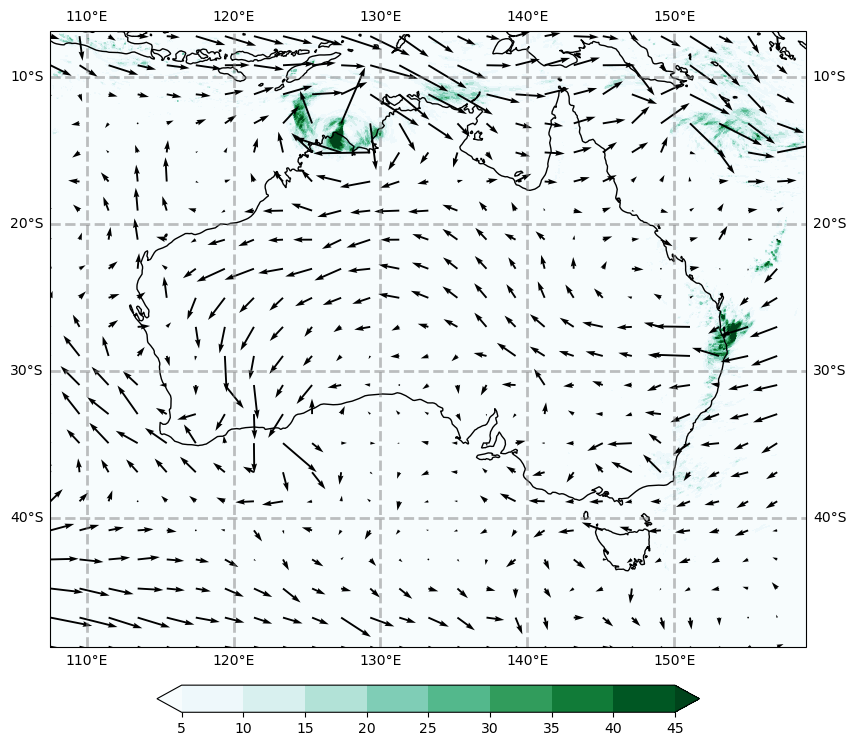

In [65]:
# Plot
interval = 100
lon2d, lat2d = np.meshgrid(lon[0:2600:interval], lat[0:2120:interval])
lon2dall, lat2dall = np.meshgrid(lon, lat)

levels = np.arange(5,50,5)
plt.figure(figsize=(10, 10))
src = ccrs.PlateCarree()
ax = plt.axes(projection=src)
cmap=matplotlib.cm.get_cmap('BuGn')


ch = ax.contourf(lon2dall, lat2dall, prcp, levels=levels, cmap=cmap, extend='both')
ax.quiver(lon2d, lat2d, u[0,0:2120:interval,0:2600:interval], v[0,0:2120:interval,0:2600:interval])
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=2, color='gray', alpha=0.5, linestyle='--')
ax.coastlines('50m', linewidth=1)
out=plt.colorbar(ch,cax=cax,extend='both',**kw)
#out.set_label('Daily Precipitation [mm / day]',size=20)
#fname = 'daily_average_precip_GPCP'
#plt.savefig(fname)

To do: Put cross section line onto map

## Calculate cross section 

In [96]:
# Taken from metpy cross section example

# use MetPy’s CF parsing to get the data ready for use
data = ds.metpy.parse_cf()
#Define start and end points:


start = (-28.0, 145)
end = (-28.0, 158)
#Get the cross section, and convert lat/lon to supplementary coordinates:

crossu = cross_section(data.fld_s00i002, start, end, 50)
crossv = cross_section(data.fld_s00i003, start, end, 50)
crossw = cross_section(data.fld_s00i150, start, end, 50)
crossq = cross_section(data.fld_s00i010, start, end, 50)

In [97]:
dsrefl = xr.open_mfdataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/netcdf/day5/history/atm/netCDF/umnsa_cldrad_20220226T0000_1h.nc')
datarefl = dsrefl.metpy.parse_cf()
                          
crossrefl = cross_section(datarefl.fld_s04i118, start, end, 50)

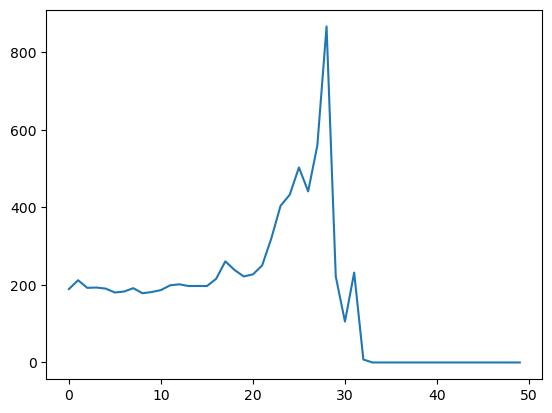

In [98]:
# Get Orography

fnameorog = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/orog_1hr_20220222_20220307.nc'
dsoro_all = xr.open_dataset(fnameorog)


dataoro_all = dsoro_all.metpy.parse_cf()
dataoro = dataoro_all.sel(time=slice('2022-02-22T00:00:30.000000000'))
#print(dataoro.orog)
crossoro = cross_section(dataoro.orog[:,:], start, end, 50)

plt.plot(crossoro[0,:])

In [99]:
print(np.shape(crossu))
print(np.shape(levels))
print(np.shape(crossoro))

mlevs = ds.theta_level_height
print(mlevs)
# Add the orogoraphy to the level heights
heights_agl = np.empty(np.shape(crossu[0,:,:]))
along_axis = np.empty(np.shape(crossu[0,:,:]))

for i in np.arange(0,70):
    heights_agl[i,:] = mlevs[i] + crossoro[0,:]
    along_axis[i,:] = np.arange(0,50)
    
print(np.shape(heights_agl))

(1, 70, 50)
(70,)
(1, 50)
<xarray.DataArray 'theta_level_height' (model_theta_level_number: 70)>
dask.array<open_dataset-e5fff788f58f3fa61fc1c93ff93d5a1btheta_level_height, shape=(70,), dtype=float64, chunksize=(70,), chunktype=numpy.ndarray>
Coordinates:
  * model_theta_level_number  (model_theta_level_number) int32 1 2 3 ... 69 70
    theta_level_height        (model_theta_level_number) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    sigma_theta               (model_theta_level_number) float64 dask.array<chunksize=(70,), meta=np.ndarray>
Attributes:
    bounds:     theta_level_height_bnds
    units:      m
    long_name:  level_height
    positive:   up
(70, 50)


In [100]:
np.shape(crossrefl)

(1, 70, 50)

<xarray.DataArray 'fld_s00i150' (time: 1, model_theta_level_number: 70,
                                 index: 50)>
dask.array<dask_aware_interpnd, shape=(1, 70, 50), dtype=float32, chunksize=(1, 70, 50), chunktype=numpy.ndarray>
Coordinates:
  * time                      (time) datetime64[ns] 2022-02-26T01:00:00
    metpy_crs                 object Projection: latitude_longitude
  * model_theta_level_number  (model_theta_level_number) int32 1 2 3 ... 69 70
    theta_level_height        (model_theta_level_number) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    sigma_theta               (model_theta_level_number) float64 dask.array<chunksize=(70,), meta=np.ndarray>
    lon_0                     (index) float64 145.0 145.3 145.5 ... 157.7 158.0
    lat                       (index) float64 -28.0 -28.01 ... -28.01 -28.0
  * index                     (index) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
Attributes:
    standard_name:    upward_air_velocity
    long_name:        W COM

/jobfs/72409276.gadi-pbs/ipykernel_395628/3281073399.py:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fname = 'onshore_flow_t'+np.str(tt)


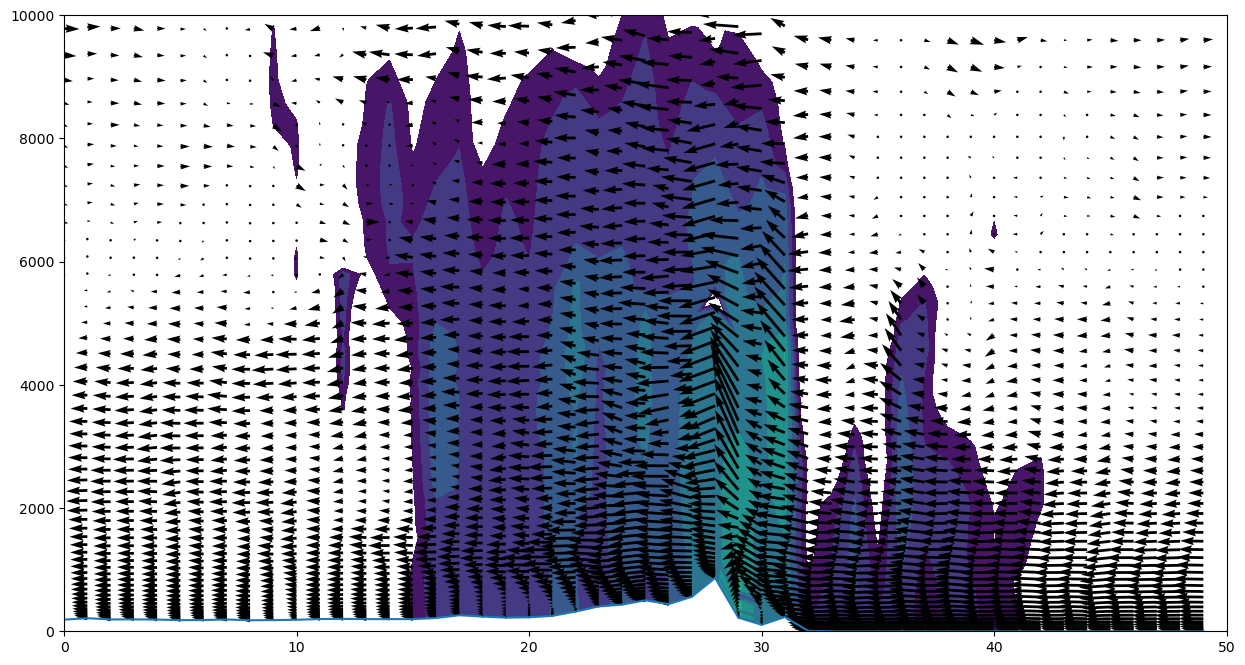

In [101]:
for tt in np.arange(0,1):
    plt.figure(figsize=(15, 8))
    print(crossw)
    levels = data.rho_level_height.values
    plt.contourf(along_axis, heights_agl, crossrefl[tt,:,:], levels = np.arange(0,100,10))
    plt.quiver(along_axis, heights_agl,  crossu[tt,:,:], crossw[tt,:,:]*10, scale=600)
    plt.plot(np.arange(0,50), crossoro[0,:])
    ax = plt.gca()
    ax.set_xlim([0, 50])
    ax.set_ylim([0,10000])
    fname = 'onshore_flow_t'+np.str(tt)
    plt.savefig('/home/563/clv563/2022_rain/onshoreplots/'+fname)
#plt.contourf(np.arange(0,200), levels, crossq[0,:,:])

To do: 
- Fix x-axis to be units of distance
- Increase number of points in cross section
- Fix scale of wind arrows
- Make this plot with cloud hydrometeors
- Loop over times during the day and make animation